In [1]:
import os
import sys
import traceback
import functools
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import theano
import theano.tensor as T
import lasagne
import neural_networks as nn 
from params import nnet_params, hyperparameter_space
from params import min_len, max_len, int_maj, batch_size, val_size, test_size
from music_utils import generateSequence
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# generate data for interval major
data = {'train': generateSequence(batch_size, int_maj, min_len, max_len),
        'valid': generateSequence(val_size, int_maj, min_len, max_len),
        'test': generateSequence(test_size, int_maj, min_len, max_len)}

# select model and params
model = 'rnn_proll'
params = nnet_params[model]

# change input shape to take any batch size
params['input_shape'] = (None, params['input_shape'][1], params['input_shape'][2])
params['input_shape']

# build the neural network model
layers = nn.build_rnn_proll(
    params['input_shape'],
    params['mask_shape'],
    params['n_hidden'],
    params['grad_clip'],
    params['init'],
    params['non_linearities'])

# generate updates-creating function
updates_function = functools.partial(params['update_func'], 
                                     learning_rate=0.1, 
                                     rho=0.95)

# create a list of epochs and keep track of lowest objective found so far
epochs = []
best_objective = np.inf

In [3]:
try:
    for epoch in nn.train_rnn_proll(data, layers, updates_function, params['batch_size'], params['epoch_size']):
        # Stop training if a nan training cost is encountered
        if not np.isfinite(epoch['train_cost']):
            break
        epochs.append(epoch)
        if epoch['validate_objective'] < best_objective:
            best_objective = epoch['validate_objective']
            best_epoch = epoch
            best_model = lasagne.layers.get_all_param_values(layers)
        print "{}: {}, {}, {} ".format(
            epoch['iteration'],
            epoch['train_cost'],
            epoch['validate_cost'],
            epoch['validate_objective'])
        sys.stdout.flush()
        if epoch['iteration'] == params['batch_size'] * 8:
            print 'Reached epoch {}'.format(epoch)
            break
# If there was an error while training, report it to whetlab
except Exception:
    print "ERROR: "
    print traceback.format_exc()

Training and Validating ...
64: 2.05809526362, 1.34879265765, 0.06640625 
128: 1.38141355472, 0.352521190255, 0.0 
192: 1.00271411276, 0.156107583624, 0.0 
256: 0.781473768307, 0.0781945167173, 0.0 
320: 0.638911997652, 0.0470070158121, 0.0 
384: 0.539618282824, 0.0340738927639, 0.0 
448: 0.46662847512, 0.0245173195071, 0.0 
512: 0.410842438412, 0.01815494054, 0.0 
576: 0.366896384187, 0.0133882026729, 0.0 
640: 0.331481728676, 0.0118858516989, 0.0 
704: 0.302286157762, 0.00884706488902, 0.0 
768: 0.277821027529, 0.00785882256091, 0.0 
832: 0.257019688383, 0.00685945302208, 0.0 
896: 0.239149011953, 0.00570278906304, 0.0 
960: 0.223595857685, 0.00579610207008, 0.0 
1024: 0.20994557505, 0.00442658046667, 0.0 
Reached epoch {'train_cost': 0.20994557504980335, 'validate_objective': 0.0, 'validate_cost': 0.0044265804666731275, 'iteration': 1024, 'patience': 5800.0}


In [4]:
print
# Check that all training costs were not NaN; return NaN if any were.
success = np.all([np.isfinite(e['train_cost']) for e in epochs])
if np.isinf(best_objective) or len(epochs) == 0 or not success:
    print '    Failed to converge.'
    print
else:
    for k, v in best_epoch.items():
        print "\t{:>35} | {}".format(k, v)
    print


	                         train_cost | 1.38141355472
	                 validate_objective | 0.0
	                      validate_cost | 0.352521190255
	                          iteration | 128
	                           patience | 1640.0



In [5]:
input_var = layers[0].input_var
mask_var = layers[1].input_var
target_var = T.imatrix('target')
prediction_tn = lasagne.layers.get_output(layers[2], deterministic=True)
err_rate_tn = T.mean(T.neq(T.argmax(prediction_tn, axis=1), T.argmax(target_var, axis=1)),
                     keepdims=True)
err_rate_fn = theano.function(inputs=[input_var, target_var, mask_var], outputs=[err_rate_tn])
prediction_fn = theano.function(inputs=[input_var, mask_var], outputs=prediction_tn)

In [6]:
input_data, target_data, mask_data = data['test'].next()
prediction = prediction_fn(input_data, mask_data)
err_rate = err_rate_fn(input_data, target_data, mask_data)
print "Error rate: {}".format(err_rate)

Error rate: [array([ 0.])]


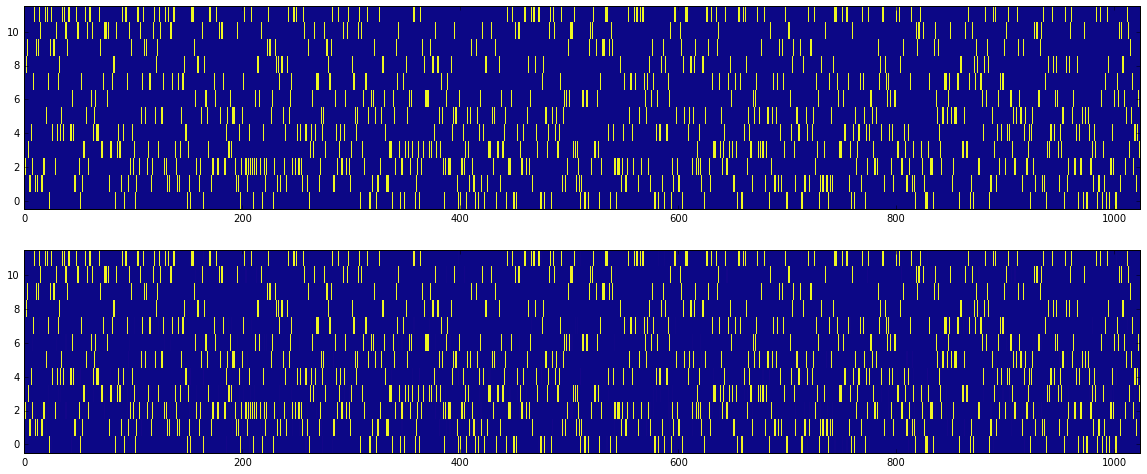

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
axes[0].imshow(target_data.T,
               aspect='auto', origin='low', interpolation='nearest',
               cmap=plt.cm.plasma)
axes[1].imshow(prediction.T,
               aspect='auto', origin='low', interpolation='nearest',
               cmap=plt.cm.plasma)

In [8]:
input_data, target_data, mask_data = data['test'].next()

In [9]:
i = 2
print input_data[i]
print mask_data[i]
print target_data[i]
print np.argmax(prediction_fn([input_data[i]], [mask_data[i]]))

[[0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0]]
[1 1 1 1 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 1]
11


In [10]:
# prepare date for prediction tests
input_test = np.zeros((2, len(int_maj), 12), dtype=np.int32)
mask_test = np.zeros((2, len(int_maj)), dtype=np.int32)
input_test[0, 0, 0] = 1
input_test[0, 1, 2] = 1
input_test[1, 0, 0] = 1
input_test[1, 1, 2] = 1
input_test[1, 2, 4] = 1
mask_test[0, :2] = 1
mask_test[1, :3] = 1
print 'Input Test\n{}'.format(input_test)
print 'Mask Test\n{}'.format(mask_test)

Input Test
[[[1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]]

 [[1 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0]]]
Mask Test
[[1 1 0 0 0 0 0]
 [1 1 1 0 0 0 0]]


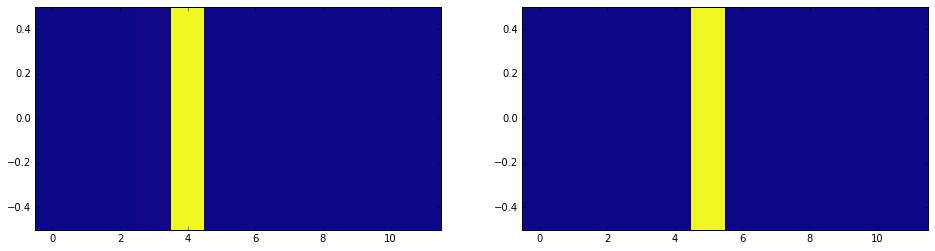

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].imshow(prediction_fn([input_test[0]], [mask_test[0]]),
           aspect='auto', origin='low', interpolation='nearest',
           cmap=plt.cm.plasma)
axes[1].imshow(prediction_fn([input_test[1]], [mask_test[1]]),
           aspect='auto', origin='low', interpolation='nearest',
           cmap=plt.cm.plasma)

In [12]:
# hack for multi-step prediction
for i in range(2, len(int_maj)):
    # Pick the character that got assigned the highest probability
    p_i = np.argmax(prediction_fn([input_test[0]], [mask_test[0]]))
    # Alternatively, to sample from the distribution instead:
    # ix = np.random.choice(np.arange(vocab_size), p=probs(x).ravel())
    input_test[0, i, p_i] = 1
    mask_test[0, i] = 1
print "Predicted from C\n{}".format(input_test[0])

Predicted from C
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]]


In [13]:
# hack for multi-step prediction
for i in range(3, len(int_maj)):
    # Pick the character that got assigned the highest probability
    p_i = np.argmax(prediction_fn([input_test[1]], [mask_test[1]]))
    # Alternatively, to sample from the distribution instead:
    # ix = np.random.choice(np.arange(vocab_size), p=probs(x).ravel())
    input_test[1, i, p_i] = 1
    mask_test[1, i] = 1

print "Predicted from C\n{}".format(input_test[1])

Predicted from C
[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]]
